In [2]:
imports_path = ".\\imports.ipynb"
tableGAN_path = ".\\tableGAN.ipynb"
utils_path = ".\\utils.ipynb"

%run "$imports_path"

In [3]:
%run "$utils_path"
%load_ext line_profiler
data= pd.read_csv('.\\df_adult_edited.csv')
data
data.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education.Num      int64
Marital.Status    object
Occupation        object
Race              object
Sex               object
Capital.Gain       int64
Hours.per.week     int64
Country           object
Salary            object
dtype: object

In [32]:
%run "$tableGAN_path"
tg = TableGAN(data, n_critic = 10, adam_lr = 0.002, adam_beta1 =0.5, ckpt_dir = ".\\Model\\tableGAN_ckpt\\adult",
              quantile_transformation_int = True, quantile_rand_transformation = True,
             noise_discrete_unif_max = 0.05)
#tg.inv_data_transform(tg.data_num_scaled, tg.data_discrete_oh)
#tg.discriminator.summary()
#tf.keras.utils.plot_model(tg.generator) #rankdir ="LR" for horizontal plot

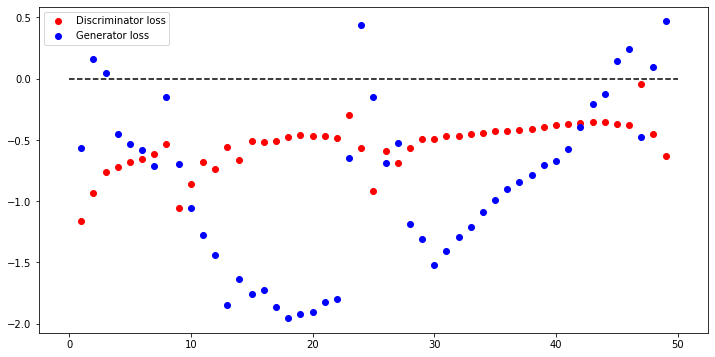

In [33]:
#%lprun -f tg.train
n_epochs = 50
fig_loss_adult, fig_time_plot = tg.train(n_epochs, batch_size = 5000, ckpt_every = 1,
                                         restart_training = True, time_plot = True, loss_plot_update_every = 1)

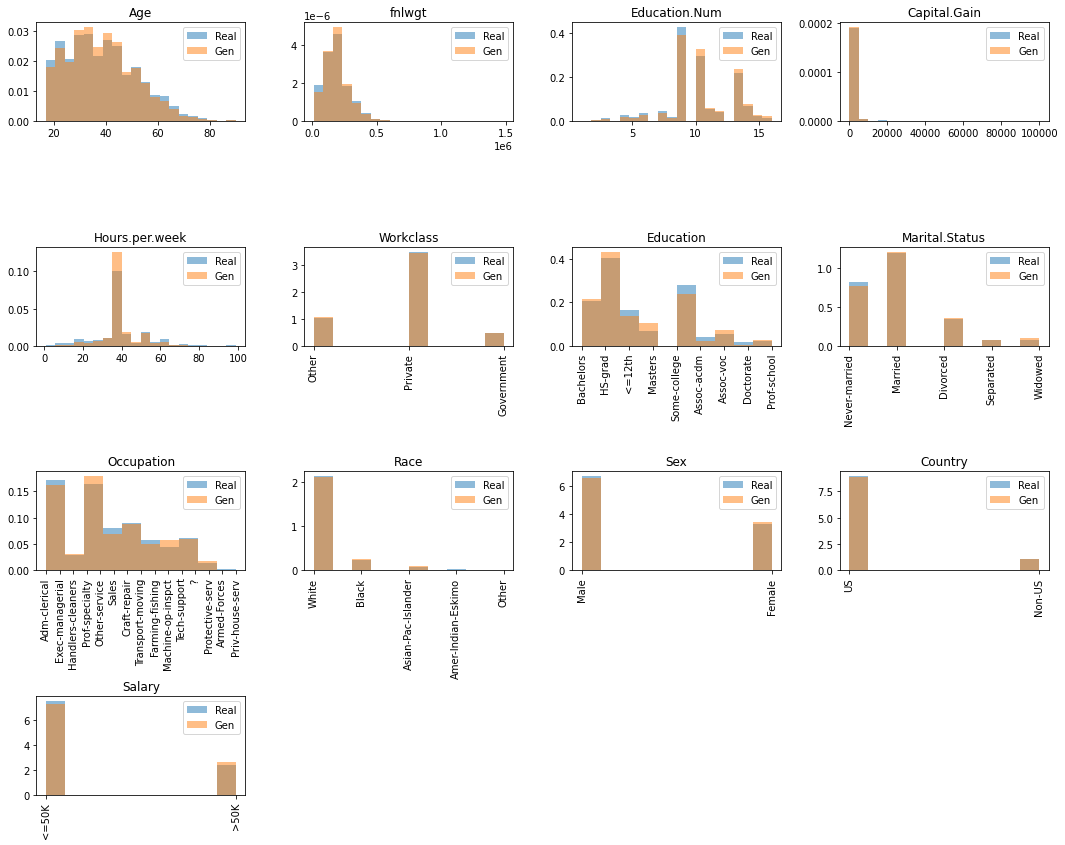

In [34]:
#tg.restore_checkpoint()
# Evaluating generating skill for the trained model. Will below check earlier epoch since perhaps the
# model started becoming worse again
compare_hist_real_vs_generated(tg, discrete_xtick_rotation = 90)

In [35]:
%run "$utils_path"
epochs_to_plot = np.unique(np.linspace(1, n_epochs, 50, dtype = np.int).tolist())
filename_compare_hist_gif = compare_evolution_hist_real_vs_generated(tg, epochs = epochs_to_plot, seed = 1, fps = 1)

  0%|          | 0/50 [00:00<?, ?it/s]

In [36]:
#play_gif(filname_compare_hist_gif, fps = 1)
filename_compare_hist_mp4 = gif_to_mp4(filename_compare_hist_gif)
Video(filename_compare_hist_mp4, embed =True)

Moviepy - Building video compare_hist_real_vs_generated.mp4.
Moviepy - Writing video compare_hist_real_vs_generated.mp4



Moviepy - Done !
Moviepy - video ready compare_hist_real_vs_generated.mp4


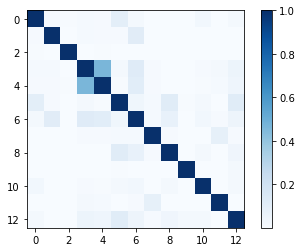

In [109]:
%run "$utils_path"
nmi_matrix = compute_nmi_matrix(tg, generated_data =True, dataset = None)
ax = plt.subplot()
plt.imshow(nmi_matrix, cmap = plt.cm.Blues)
plt.colorbar()

In [103]:
bins["Capital.Gain"]

array([    0.        ,   728.30059814,  4242.46142578,  7688.        ,
       99999.        ])

['True dataset', 'tg1', 'tg2', 'tg3']


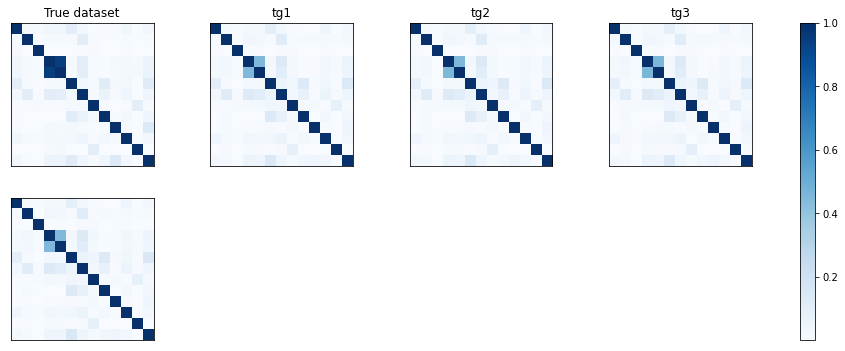

In [19]:
%run "$utils_path"

compare_nmi_matrices([tg, tg, tg], extra_datasets = [tg.generate_data()],
                    ncol = 4, subplot_titles_tgans =  ["tg1", "tg2", "tg3"])

In [41]:
corr = 0.5
n = 100000
x1 = np.random.choice([0,1], n, p = [0.2, 0.8])
x2 = np.where(x1 == 1,
              np.random.choice([2,3], n, p =[0.5 - 0.5*corr, 0.5 +0.5*corr]),
              np.random.choice([2,3], n, p = [0.5 + 0.5*corr, 0.5 - 0.5*corr]))
print(np.corrcoef(x1,x2))
data_binned = pd.DataFrame({"x1" : x1, "x2" : x2})
probs_dict = {} 
columns = ["x1", "x2"]
entropy_max = np.zeros([len(columns)])
for i,col in enumerate(columns):
    col_category_fractions = data_binned[col].value_counts(normalize = True)
    probs_dict[col] = col_category_fractions.to_dict()
    entropy_max[i] = np.max(-np.log(col_category_fractions))
    print(np.log(col_category_fractions))

print("entropy_max", entropy_max)
    
df_curr_cols_fraction = data_binned.groupby(["x1","x2"]).size().reset_index().rename(columns={0:"Prob.both"})
df_curr_cols_fraction["Prob.both"] /= n
print(df_curr_cols_fraction)
df_curr_cols_fraction["Prob.col1"] = df_curr_cols_fraction["x1"].map(probs_dict["x1"]).astype(float)
df_curr_cols_fraction["Prob.col2"] = df_curr_cols_fraction["x2"].map(probs_dict["x2"]).astype(float)
df_curr_cols_fraction["NMI"] = df_curr_cols_fraction["Prob.both"] * np.log(df_curr_cols_fraction["Prob.both"]/
                                                                                           (df_curr_cols_fraction["Prob.col1"]*df_curr_cols_fraction["Prob.col2"]))
nmi = 2 * np.sum(df_curr_cols_fraction["NMI"]) / np.min([entropy_max[0] * entropy_max[1]])
print(nmi)
print(np.sum(df_curr_cols_fraction["NMI"]) / np.min([entropy_max[0],entropy_max[1]]))

from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import adjusted_mutual_info_score
print(normalized_mutual_info_score(x1, x2))
print("Adjusted:", adjusted_mutual_info_score(x1, x2))
    

[[1.         0.41432729]
 [0.41432729 1.        ]]
1   -0.221782
0   -1.614903
Name: x1, dtype: float64
3   -0.430629
2   -1.050108
Name: x2, dtype: float64
entropy_max [1.61490282 1.05010788]
   x1  x2  Prob.both
0   0   2    0.14848
1   0   3    0.05043
2   1   2    0.20142
3   1   3    0.59967
0.09792077289288773
0.07906626603612976
0.14486628487747258
Adjusted: 0.14485882446277923


ValueError: Input array must be 1 dimensional